In [1]:
from pathlib import Path
import geopy.distance
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import xarray
import json
from datetime import datetime

import intake
from adjustText import adjust_text

## Monthly mean precipitation from GPCP

In [2]:
path = Path('../Data')

In [3]:
precipMonthlyMean = xarray.open_mfdataset(path/'gpcpPrecipMonthlyMean.nc')
precipMonthlyStdFromDaily = xarray.open_mfdataset(path/'gpcpPrecipMonthlyStd.nc')

In [4]:
cat = intake.open_catalog('https://tcodata.mpimet.mpg.de/internal.yaml')
precipCwvHourly = cat.ORCESTRA.orcestra_preparations_era5.to_dask()

# Coordinates

### General

In [5]:
lonMin, lonMax = -60, -10
latMin, latMax = -10, 30

In [6]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
               'lasPalmasNorth': 28.15, 'lasPalmasEast': -15.42
              } 
latitudePirata = [-10,0,15,0,8,0,12,4,0,-6,0,-8,-14,-19,12,4,-6,21,20]
longitudePirata = [-10,-10,-38,-35,-38,0,-38,-38,-23,-10,-23,-30,-32,-34,-23,-23,8,-23,-38]

### Ship coordinates

In [7]:
coordinatesShip = {'turnNorth': 14.5, 
                   'turnCenterLat': 7.5, 
                   'turnSouth': 2.5, 
                   'turnSouthForLegWest': 5,
                   'turnSouthForPirata': -0.5,
                   'turnEast': -23, #Pirata at -23
                   'turnCenterLon': -32, #Pirata at -38
                   'turnWest': -47,
                  }

conversionKnKmH = 1.852

shipValues = {
              'averageSpeedKmH': 10*conversionKnKmH,
              'ctdTimePerDegLat': 1.5
             }

eastWestOffset = 0.4
northSouthOffset = 0.4

### Ship track

In [8]:

shipTrackTransitStart = [(coordinates['mindeloNorth'], coordinates['mindeloEast'])]

shipTrackLegEast = [ 
             (coordinatesShip['turnNorth'], coordinatesShip['turnEast']),
             (coordinatesShip['turnSouthForPirata'], coordinatesShip['turnEast']),
             (coordinatesShip['turnNorth'], coordinatesShip['turnEast']-eastWestOffset),
             (coordinatesShip['turnSouth'], coordinatesShip['turnEast']-eastWestOffset),
             (coordinatesShip['turnCenterLat'], coordinatesShip['turnEast']-eastWestOffset*2)
                   ]

shipTrackLegCenter = [
                      (coordinatesShip['turnCenterLat'], coordinatesShip['turnCenterLon']),
                      (coordinatesShip['turnNorth'], coordinatesShip['turnCenterLon']),
                      (coordinatesShip['turnSouth'], coordinatesShip['turnCenterLon']-eastWestOffset),
                      (coordinatesShip['turnNorth'], coordinatesShip['turnCenterLon']-eastWestOffset),
                      (coordinatesShip['turnCenterLat'], coordinatesShip['turnCenterLon']-eastWestOffset*2)            
                   ]

shipTrackLegWest = [
                    (coordinatesShip['turnCenterLat'], coordinatesShip['turnWest']),
                    (coordinatesShip['turnNorth'], coordinatesShip['turnWest']),
                    (coordinatesShip['turnSouthForLegWest'], coordinatesShip['turnWest']-eastWestOffset),
                    (coordinatesShip['turnCenterLat']+northSouthOffset, coordinatesShip['turnWest']-eastWestOffset),
                    (coordinatesShip['turnNorth']+northSouthOffset, coordinatesShip['turnWest']-eastWestOffset),
                   ]

shipTrackTransitEnd = [(coordinates['bcoNorth'], coordinates['bcoEast'])]

shipTrack = shipTrackTransitStart + shipTrackLegEast + shipTrackLegCenter + shipTrackLegWest + shipTrackTransitEnd
shipLat, shipLon  = zip(*shipTrack)

In [9]:
def calcShipTrackTime(shipTrack, startDate, shipSpeedKmH):
    
    shipTrackTime = [startDate]
    
    totalWorkingTimeH = 0
    totalStationTimeH = 0
    
    for shipInd in range(1, len(shipTrack)):
        coords_1 = shipTrack[shipInd]
        coords_2 = shipTrack[shipInd-1]
        
        # Travel time
        distanceKm = geopy.distance.geodesic(coords_1, coords_2).km
        travelTime = distanceKm/shipSpeedKmH
        timeH = travelTime
        
        # Station time (CTD time per latitudinal degree outside transit)
        if (coords_1 not in (shipTrackTransitStart + shipTrackTransitEnd)) & (coords_2 not in (shipTrackTransitStart + shipTrackTransitEnd)):
            latDistance = int(np.ceil(np.abs(coords_1[0]-coords_2[0])))
            stationTime = latDistance*shipValues['ctdTimePerDegLat']
            
            totalWorkingTimeH+=travelTime+stationTime
            totalStationTimeH+=stationTime
            timeH += stationTime
        
        shipIndTime = shipTrackTime[shipInd-1] + np.timedelta64(int(np.ceil(timeH)), 'h')

        shipTrackTime.append(shipIndTime)
        
    return shipTrackTime, np.timedelta64(int(totalWorkingTimeH), 'h'), np.timedelta64(int(totalStationTimeH), 'h')

## Ship location as a function of time

In [10]:
startDate = np.datetime64('2023-08-10T12:00')
shipTrackTime, totalWorkingTimeShip, totalStationTimeShip = calcShipTrackTime(shipTrack, startDate, shipValues['averageSpeedKmH'])
print(f"""Number of working days: {np.timedelta64(totalWorkingTimeShip, 'D')}, 
Total station time {np.timedelta64(totalStationTimeShip, 'D')}""")

Number of working days: 40 days, 
Total station time 7 days


In [11]:
track_dic = {'track_lon': shipLon, 'track_lat': shipLat, 'track_time': shipTrackTime}

# Save the dictionary to a JSON file
with open('track.json', 'w') as json_file:
    json.dump(track_dic, json_file, default=str)

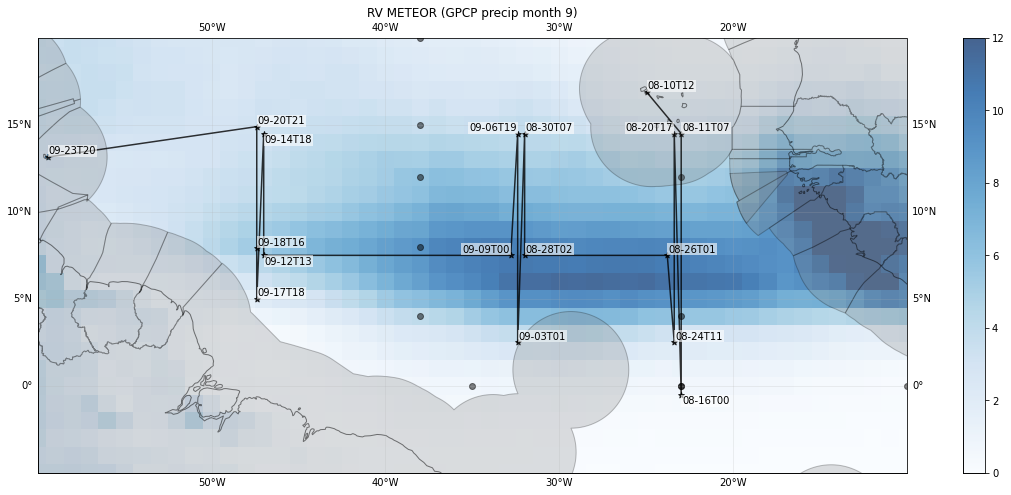

In [12]:
plt.figure(figsize = (20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = './EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
ax.add_feature(shape_feature,zorder=1)


precipMonth = 9
time = datetime(2001, 8, 31, 12, 0, 0)
#time = random.choice(ds.time).values

plot_mean = True

if plot_mean:
    
    precipField = precipMonthlyMean
    plt.pcolormesh(precipField.sel(month=precipMonth).longitude.values-360.0, 
                   precipField.sel(month=precipMonth).latitude.values,
                   precipField.sel(month=precipMonth).precip.values,
                   vmin = 0.0, vmax = 12.0, cmap = 'Blues', alpha = 0.75,
                   shading='nearest'
                  )
    
    plt.colorbar()
    
    plt.title(f"RV METEOR (GPCP precip month {precipMonth})")
    
else:

    
    field = precipCwvHourly.sel(time = time, method = 'nearest').tcwv
    levels_cwv = [45, 50, 55]

    plt.pcolormesh(field.longitude.values, 
                   field.latitude.values,
                   field.values,
                   alpha = 0.75,
                   shading='nearest', 
                   cmap = 'Blues',
                   vmin = levels_cwv[0], vmax = 65
                  )
    plt.colorbar()

    contour_lines = plt.contour(field.longitude.values, 
                                field.latitude.values,
                                field.values,  # Change this to your data
                                levels=levels_cwv,  # Contour levels
                                colors='k',  # Contour line color (black)
                                linewidths=1,  # Contour line width
                                alpha = 0.5
                               )

    # Add labels to the contour lines
    plt.clabel(contour_lines, inline=True, fontsize=10, colors='k', fmt='%d')
    
    plt.title(f"RV METEOR (ERA5 {precipCwvHourly['tcwv'].long_name} {time})")
    

plt.scatter(longitudePirata, latitudePirata, color = 'k', label = 'PIRATA', alpha = 0.5)
plt.scatter(coordinates['bcoEast'], coordinates['bcoNorth'], marker = '+')

plt.xlabel("Longitude [°E]")
plt.ylabel("Latitude [°N]")


ax.set_xlim(lonMin, lonMax)
ax.set_ylim(-5, 20)

plt.scatter(shipLon,shipLat, alpha=0.8, color = 'k', marker = '*')
p1 = plt.plot(shipLon,shipLat, alpha=0.8, color = 'k')
texts = []
for x, y, s in zip(shipLon, shipLat, shipTrackTime):
    texts.append(plt.text(x, y, str(s)[5:-3], color = 'k', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts, longitudePirata+list(shipLon), latitudePirata+list(shipLat), force_text = (1.5, 0.5))

sn.despine()

## Distance to travel for HALO

In [13]:
coords_1 = (coordinates['bcoNorth'], coordinates['bcoEast'])
coords_2 = (coordinatesShip['turnCenterLat'], -45)
distanceKm = geopy.distance.geodesic(coords_1, coords_2).km
print(f'{int(distanceKm)}km')

1697km


In [14]:
coords_1 = (coordinates['mindeloNorth'], coordinates['mindeloEast'])
coords_2 = (coordinatesShip['turnCenterLat'], -30)
distanceKm = geopy.distance.geodesic(coords_1, coords_2).km
print(f'{int(distanceKm)}km')

1172km
